# Calculate Compound Years for CESM

This file grabs the warm season indeces and sees if this shows us anything


You need to run cesmIndeces.ipnyb first

In [1]:
#For plots of a single experiment to demonstrate things, plot this one:

expToPlot = 'LME.002'

In [2]:
#import my functions
import utils._modelDefinitions as _model
import utils._indexDefinitions as _index
from utils.timePeriod import averageForTimePeriod

%run "utils/compound.ipynb"

In [3]:
import xarray
import matplotlib.pyplot as plt
import numpy
import pandas

%matplotlib inline

In [4]:
# Here is the data
indecesDa = xarray.load_dataarray('results/cesmTradIndeces.nc')

indecesDa.experiment.values

array(['LME.002', 'LME.003', 'LME.008', 'LME.009', '001', '002', '003',
       '004', '005', '006', '007', '008', '009', '010', '011', '012',
       '013'], dtype=object)

# Define a criteria to determine events, and plot an example

So we are going to define events as follows:
- For SST indeces (aka Enso and Iod), this is 1 sigma above/below mean
- For PSL indeces (aka Sam) this is 0.5 sigma above/below mean

For now, using a 850-1850 climatology

In [5]:
# This should calculate stds for all experiments and all indeces
stdDa = indecesDa.std(dim='year')

# define some criteria that we want to use to identifiy it thats an event
criteriaDa = xarray.concat(
    (stdDa.sel(index=['nino34','dmi']), stdDa.sel(index='sam')/2),
    'index'
)

CESM Model Run: LME.002


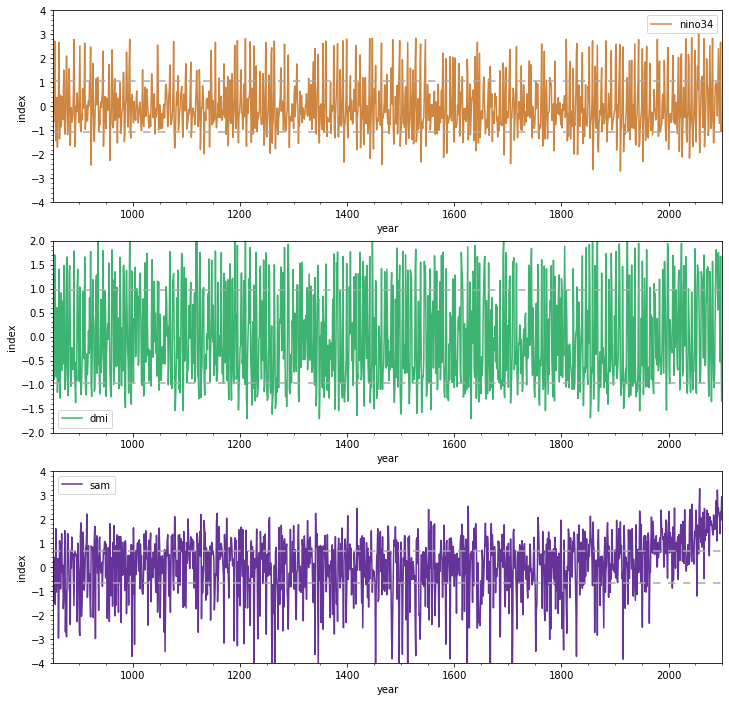

In [6]:
# plot indeces for an experiment, and add some lines for +- 1 sigma

indexToPlot = ['nino34', 'dmi', 'sam']
colors = ['peru', 'mediumseagreen', 'rebeccapurple']
lims = [(-4,4), [-2,2], [-4,4]]

print('CESM Model Run: ' + expToPlot)

# first define somewhere to plot
fig = plt.figure(figsize=(12,12))

for i in range(3):
    
    fig.add_subplot(3,1,i+1)
    
    # plot the actual data
    plotData=indecesDa.sel(experiment=expToPlot, index=indexToPlot[i]) 
    plt.plot(plotData.year, plotData.values, label=indexToPlot[i], color=colors[i])
    
    # draw some horizontal lines for criteria
    eventCrit=criteriaDa.sel(experiment=expToPlot, index=indexToPlot[i]).values
    plt.axhline(y=eventCrit, dashes=(5,5), color='darkgrey')
    plt.axhline(y=-eventCrit, dashes=(5,5), color='darkgrey')

    #Tidy up a bit
    plt.xlabel('year')
    plt.ylabel('index')
    plt.xlim(850,2100)
    plt.ylim(lims[i])
    plt.minorticks_on()
    plt.legend()


# Calculate the compounding years and plot an example

In [7]:
firePos, fireNeg = applyCriteria(indecesDa, criteriaDa)

firePosCount = firePos.sum(dim='index')
fireNegCount = fireNeg.sum(dim='index')

In [8]:
firePos.index.values

array(['nino34', 'dmi', 'sam'], dtype=object)

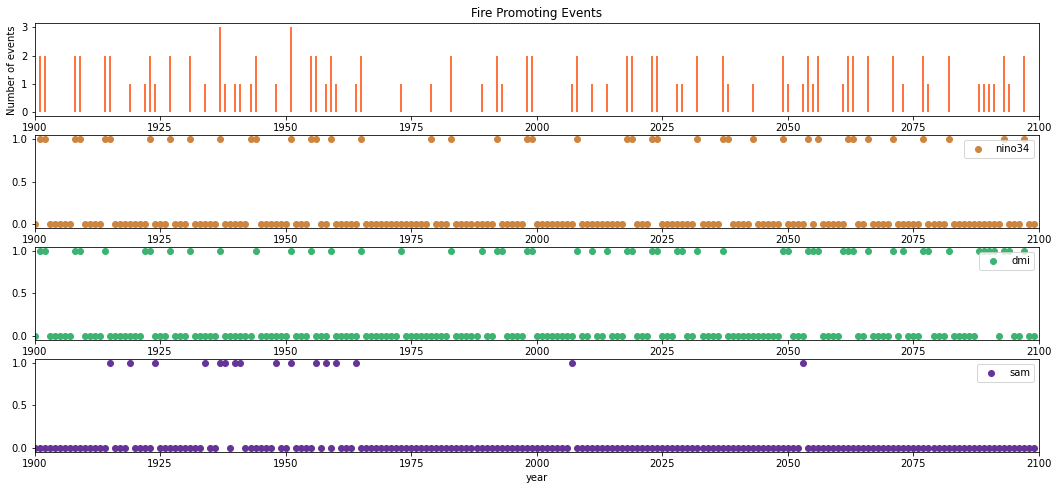

In [9]:
plt.figure(figsize=(18,12))

#plot the pos events in orange 

plt.subplot(6,1,3)

plt.vlines(
    x=firePos.year, 
    ymin=0,
    ymax=firePosCount.sel(experiment=expToPlot),
    colors='orangered', 
    label=expToPlot
)
plt.xlim(1900,2100)
plt.xlabel('year')
plt.ylabel('Number of events')
plt.title('Fire Promoting Events')


iPlot=3
for iIndex in firePos.index.values:
    iPlot=iPlot+1
    plt.subplot(6,1,iPlot)
    plt.scatter(
        x=firePos.year, 
        #ymin=0,
        y=(firePos>0).sel(experiment=expToPlot, index=iIndex),
        color=colors[iPlot-4], 
        label=iIndex
    )
    plt.legend()
    plt.xlim(1900,2100)
    plt.xlabel('year')


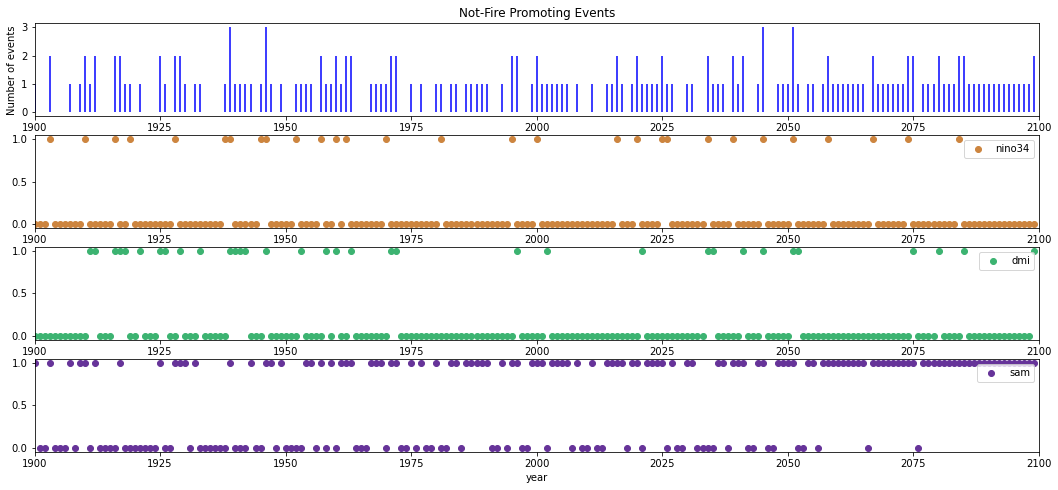

In [10]:
# and the neg count in blue

plt.figure(figsize=(18,12))

#plot the pos events in orange 

plt.subplot(6,1,3)

plt.vlines(
    x=fireNeg.year, 
    ymin=0,
    ymax=fireNegCount.sel(experiment=expToPlot),
    colors='blue', 
    label=expToPlot
)
plt.xlim(1900,2100)
plt.xlabel('year')
plt.ylabel('Number of events')
plt.title('Not-Fire Promoting Events')


iPlot=3
for iIndex in fireNeg.index.values:
    iPlot=iPlot+1
    plt.subplot(6,1,iPlot)
    plt.scatter(
        x=fireNeg.year, 
        #ymin=0,
        y=(fireNeg>0).sel(experiment=expToPlot, index=iIndex),
        color=colors[iPlot-4], 
        label=iIndex
    )
    plt.legend()
    plt.xlim(1900,2100)
    plt.xlabel('year')


# Put the compounds into 30 year intervals

In [11]:
yearBins=numpy.arange(860, 2100, 30)

binMid=numpy.arange(875, 2086, 30)

binnedFirePos=firePos.groupby_bins('year', yearBins, labels=binMid ).sum() 



binnedPosCount=(firePosCount>1).groupby_bins('year', yearBins, labels=binMid).sum() 
binnedPosCount= binnedPosCount.rename({'year_bins':'year'})


binnedNegCount=(fireNegCount>1).groupby_bins('year', yearBins, labels=binMid).sum()
binnedNegCount= binnedNegCount.rename({'year_bins':'year'})

Plot of main ensemble runs over time

Text(0.5, 1.0, 'Events in non-overlapping 30 year bins for main ensemble runs.')

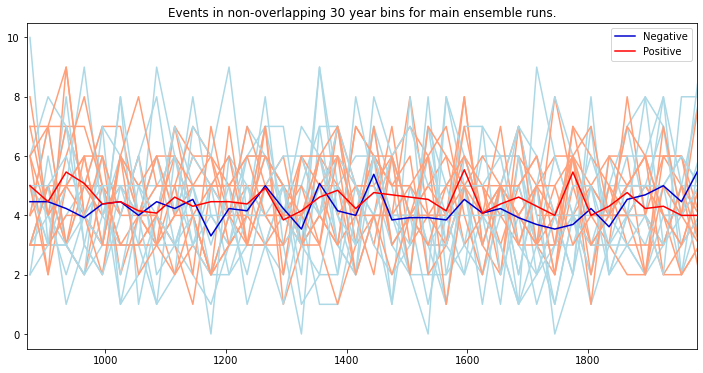

In [12]:
fig = plt.figure(figsize=(12,6))

for iExp in _model.cesmFullForcings:
    plt.plot(binnedNegCount.year, binnedNegCount.sel(experiment=iExp).values, color='lightblue')
    plt.plot(binnedPosCount.year, binnedPosCount.sel(experiment=iExp).values, color='lightsalmon')
    
plt.plot(binnedNegCount.year, binnedNegCount.sel(experiment=_model.cesmFullForcings).mean(dim='experiment') , color='mediumblue', label='Negative')
plt.plot(binnedPosCount.year, binnedPosCount.sel(experiment=_model.cesmFullForcings).mean(dim='experiment') , color='red', label = 'Positive')   

plt.xlim(870, 1980)
plt.legend()
plt.title('Events in non-overlapping 30 year bins for main ensemble runs.')

Plot of runs with RCP 8.5 forcings

Text(0.5, 1.0, 'Events in non-overlapping 30 year bins for four ensemble runs with RCP85 extension.')

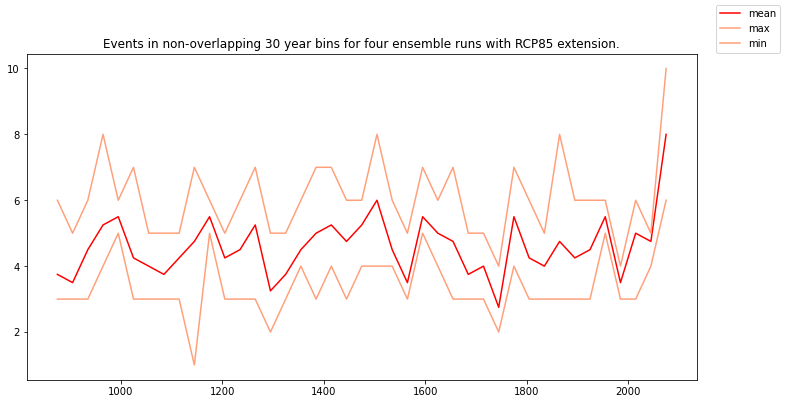

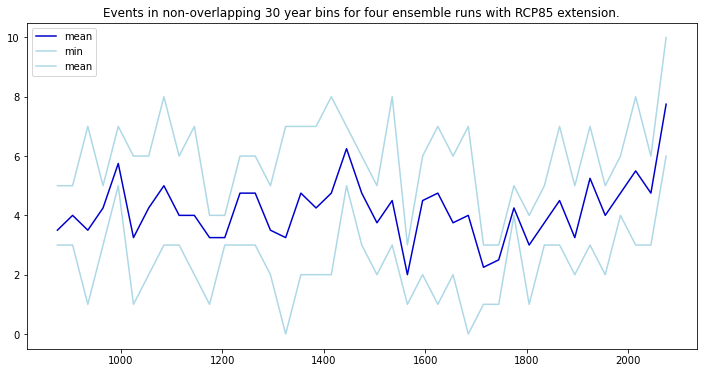

In [13]:
fig = plt.figure(figsize=(12,6))

    
plt.plot(binnedPosCount.year, binnedPosCount.sel(experiment=_model.cesmRcp85).mean(dim='experiment') , color='red', label='mean')   
plt.plot(binnedPosCount.year, binnedPosCount.sel(experiment=_model.cesmRcp85).max(dim='experiment') , color='lightsalmon', label='max')
plt.plot(binnedPosCount.year, binnedPosCount.sel(experiment=_model.cesmRcp85).min(dim='experiment') , color='lightsalmon', label='min')

fig.legend()

plt.title('Events in non-overlapping 30 year bins for four ensemble runs with RCP85 extension.')



fig = plt.figure(figsize=(12,6))
    
plt.plot(binnedNegCount.year, binnedNegCount.sel(experiment=_model.cesmRcp85).mean(dim='experiment') , color='mediumblue', label='mean')
plt.plot(binnedNegCount.year, binnedNegCount.sel(experiment=_model.cesmRcp85).max(dim='experiment') , color='lightblue', label='min')
plt.plot(binnedNegCount.year, binnedNegCount.sel(experiment=_model.cesmRcp85).min(dim='experiment') , color='lightblue', label='mean')

plt.legend()

plt.title('Events in non-overlapping 30 year bins for four ensemble runs with RCP85 extension.')

# Overlapping bins

In [14]:
overlapBinFirePos=overlappingBinSum(firePosCount>1)
overlapBinFireNeg=overlappingBinSum(fireNegCount>1)


In [15]:
overlapBinFireNeg

<xarray.DataArray (year: 123, experiment: 17)>
array([[ 6.,  4.,  4., ...,  2.,  6.,  5.],
       [ 5.,  3.,  3., ...,  2.,  6.,  4.],
       [ 5.,  3.,  1., ...,  4.,  8.,  4.],
       ...,
       [ 5.,  5.,  6., ...,  0.,  0.,  0.],
       [ 6.,  7.,  9., ...,  0.,  0.,  0.],
       [ 6., 10.,  9., ...,  0.,  0.,  0.]])
Coordinates:
  * experiment  (experiment) object 'LME.002' 'LME.003' ... '012' '013'
  * year        (year) int32 865 875 885 895 905 ... 2045 2055 2065 2075 2085
Attributes:
    Bins:     Overlapping 30 year bins, seperating by 10 year intervals
    Year:     Midpoint of bin

Text(0.5, 1.0, 'Events in non-overlapping 30 year bins for four ensemble runs with RCP85 extension.')

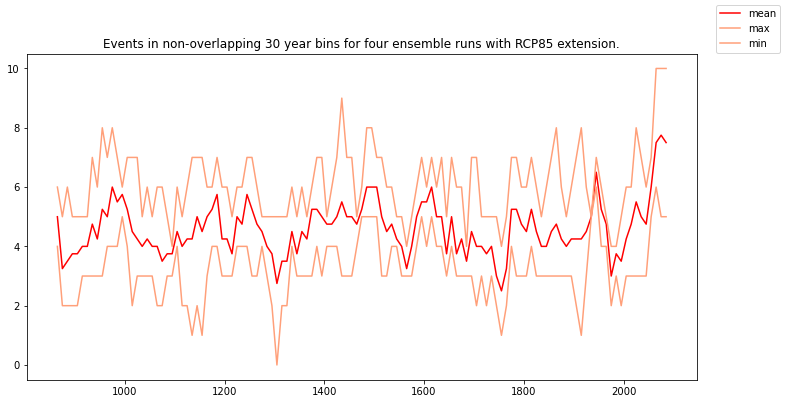

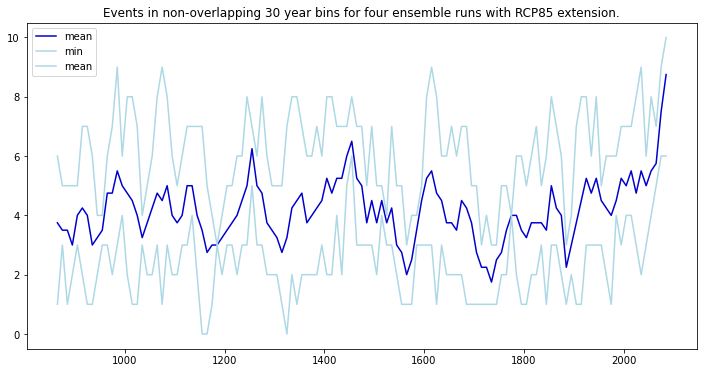

In [16]:
fig = plt.figure(figsize=(12,6))

    
plt.plot(overlapBinFirePos.year, overlapBinFirePos.sel(experiment=_model.cesmRcp85).mean(dim='experiment') , color='red', label='mean')   
plt.plot(overlapBinFirePos.year, overlapBinFirePos.sel(experiment=_model.cesmRcp85).max(dim='experiment') , color='lightsalmon', label='max')
plt.plot(overlapBinFirePos.year, overlapBinFirePos.sel(experiment=_model.cesmRcp85).min(dim='experiment') , color='lightsalmon', label='min')

fig.legend()

plt.title('Events in non-overlapping 30 year bins for four ensemble runs with RCP85 extension.')



fig = plt.figure(figsize=(12,6))
    
plt.plot(overlapBinFireNeg.year, overlapBinFireNeg.sel(experiment=_model.cesmRcp85).mean(dim='experiment') , color='mediumblue', label='mean')
plt.plot(overlapBinFireNeg.year, overlapBinFireNeg.sel(experiment=_model.cesmRcp85).max(dim='experiment') , color='lightblue', label='min')
plt.plot(overlapBinFireNeg.year, overlapBinFireNeg.sel(experiment=_model.cesmRcp85).min(dim='experiment') , color='lightblue', label='mean')

plt.legend()

plt.title('Events in non-overlapping 30 year bins for four ensemble runs with RCP85 extension.')

# Rolling 30 year intervals instead

(0.0, 8.0)

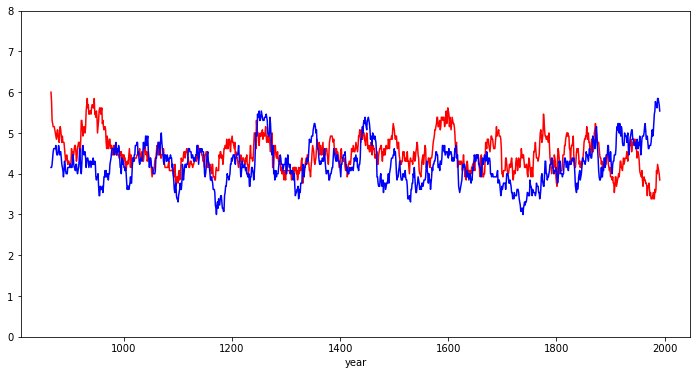

In [17]:
fig = plt.figure(figsize=(12,6))

rollingPCount=(firePosCount.where(firePosCount.year<=2005, drop=True).sel(
    experiment=_model.cesmFullForcings)>1
              ).rolling(
    year=30, center=True
).sum('year').dropna('year')

rollingPCount.mean(dim='experiment').plot(label='mean', color='red')

rollingNCount=(
    fireNegCount.where(fireNegCount.year<=2005, drop=True).sel(experiment=_model.cesmFullForcings)>1
).rolling(
    year=30, center=True
).sum('year').dropna('year')

rollingNCount.mean(dim='experiment').plot(label='mean', color='blue')


plt.ylim(0,8)